In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    average_precision_score, ConfusionMatrixDisplay, RocCurveDisplay
)
import matplotlib.pyplot as plt
target_names = ['Not taking Contract', 'Takes Contract']



In [2]:
data = pd.read_csv('data/wallacecommunications.csv', delimiter=',')
# drop the month value with 'j' as it can be January, June, July
data = data[data['last_contact_this_campaign_month'] != 'j']
# drop ID as it is just identifier and Country
data = data.drop(columns= ['ID', 'country'])
# Replace the incorrect values to correct value
data['has_tv_package'] = data['has_tv_package'].replace({'n':'no'})
data['last_contact'] = data['last_contact'].replace({'cell':'cellular'})


In [3]:
binary_cols = ['arrears', 'housing', 'has_tv_package']
for cols in binary_cols:
    data[cols] = data[cols].map({'yes':1, 'no':0})

In [4]:
data['never_contacted'] = (data['days_since_last_contact_previous_campaign'] == -1).astype(int)
data['days_since_last_contact_previous_campaign'] = (
    data['days_since_last_contact_previous_campaign'].replace(-1, np.nan)
)

In [5]:
# Taking conn_tr, last_contact_campaign_day as categorical as it a grouping of customer and date is not considered numeric as it 
# is not ordinal and have no numerical value 
categorical_features = ['job','education', 'last_contact', 'never_contacted',
                         'last_contact_this_campaign_month', 'outcome_previous_campaign','last_contact_this_campaign_day','conn_tr','town', 
                           'married']
numerical_features = ['age', 'current_balance', 'this_campaign', 'days_since_last_contact_previous_campaign', 
                      'contacted_during_previous_campaign']

In [6]:
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='constant', fill_value=999999)),
    ("scaler", StandardScaler())
])

In [7]:
data_processor = ColumnTransformer(
    transformers=[
        ('num', numeric_preprocess, numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

In [8]:
X = data.drop(columns=['new_contract_this_campaign'])
y = data['new_contract_this_campaign'].map({"yes": 1, "no": 0})

In [9]:
X_85, X_test, y_85, y_test = train_test_split(
    X, y, test_size=0.15, random_state=36, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_85, y_85, test_size=0.1765, random_state=36, stratify=y_85
)

In [10]:
lr_pl= Pipeline([
        ('preprocessor', data_processor),
        ('classifier', LogisticRegression(penalty='l1', 
                                          solver='liblinear', 
                                          max_iter=1000, 
                                          random_state=36,
                                          class_weight='balanced'))
    ])

In [11]:
lr_pl.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [12]:
y_pred = lr_pl.predict(X_val)
y_proba = lr_pl.predict_proba(X_val)[:,1]

Logistic Regression  —  Acc: 0.754 | AUC: 0.785


<Figure size 640x480 with 0 Axes>

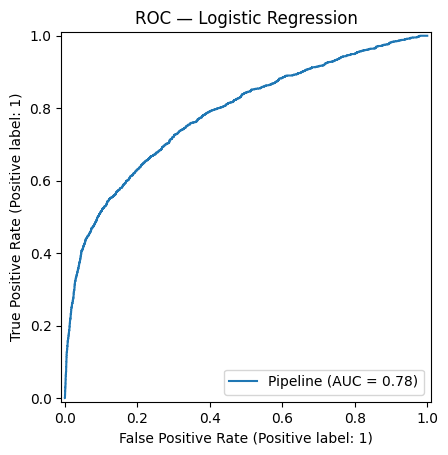

<Figure size 640x480 with 0 Axes>

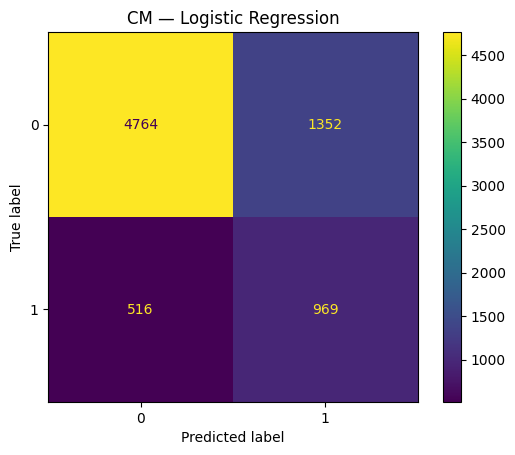


===== BASELINE MODEL ON VALIDATION FOR LOGISTIC REGRESSION =====
Accuracy: 0.754242862781213
Precision (YES): 0.4174924601464886
Recall (YES): 0.6525252525252525
F1-score: 0.509196006305833
ROC AUC: 0.7846559116343289
PR AUC: 0.5564161356507702

Confusion Matrix:
 [[4764 1352]
 [ 516  969]]

Classification Report:
                      precision    recall  f1-score   support

Not taking Contract       0.90      0.78      0.84      6116
     Takes Contract       0.42      0.65      0.51      1485

           accuracy                           0.75      7601
          macro avg       0.66      0.72      0.67      7601
       weighted avg       0.81      0.75      0.77      7601



In [13]:
print(f"Logistic Regression  —  Acc: {accuracy_score(y_val, y_pred):.3f} | AUC: {roc_auc_score(y_val, y_proba):.3f}")
fig = plt.figure(); RocCurveDisplay.from_estimator(lr_pl, X_val, y_val); plt.title("ROC — Logistic Regression"); plt.show()
fig = plt.figure(); ConfusionMatrixDisplay.from_predictions(y_val, y_pred); plt.title("CM — Logistic Regression"); plt.show()

print("\n===== BASELINE MODEL ON VALIDATION FOR LOGISTIC REGRESSION =====")
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision (YES):", precision_score(y_val, y_pred, pos_label=1))
print("Recall (YES):", recall_score(y_val, y_pred, pos_label=1))
print("F1-score:", f1_score(y_val, y_pred, pos_label=1))
print("ROC AUC:", roc_auc_score(y_val, y_proba))
print("PR AUC:", average_precision_score(y_val, y_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=target_names))

In [14]:
coefs = lr_pl.named_steps['classifier'].coef_[0]
feature_names = lr_pl.named_steps['preprocessor'].get_feature_names_out()


In [15]:
pd.set_option('display.max_rows', 500)
print("Model coefficients:\n")
coef_df = pd.DataFrame({'feature': feature_names, 'coef': abs(coefs)}).sort_values(by='coef', ascending=True)
print(coef_df)

Model coefficients:

                                            feature      coef
108                            cat__town_Hartlepool  0.000000
142                                  cat__town_Sale  0.000000
89                                cat__town_Chester  0.000000
3    num__days_since_last_contact_previous_campaign  0.000000
55           cat__last_contact_this_campaign_day_21  0.000000
35           cat__outcome_previous_campaign_unknown  0.000000
128                               cat__town_Norwich  0.000000
136                            cat__town_Portsmouth  0.000000
83                               cat__town_Brighton  0.000000
75                                cat__town_Belfast  0.000000
161                            cat__town_Warrington  0.000000
129                            cat__town_Nottingham  0.000000
0                                          num__age  0.002013
95                             cat__town_Darlington  0.004478
100                             cat__town_Edinbur

Lot of days have similar coefficient hence negating overall requirement of the date column. Town is really weak predictor, conn_tr also is not a good predictor